# **Forecast.fm**
## **Music Streams ARIMA-LSTM Hybrid Forecast**

### **Time Series Forecasting of Spotify Streams Using an ARIMA-LSTM Hybrid Model**

**Project Overview:**
This notebook presents a hybrid time series forecasting model designed to predict the daily stream counts of a specific Spotify song. The model integrates ARIMA (AutoRegressive Integrated Moving Average) and LSTM (Long Short-Term Memory) to leverage both linear and nonlinear temporal dependencies in the data.

* The ARIMA model captures the linear trend and seasonality in the time series.
* The LSTM model is applied to the residuals from the ARIMA model to learn and forecast nonlinear patterns.
* The final forecast is produced by combining the outputs of both models.

The dataset used contains historical daily stream counts for the selected song, aggregated by date. The goal is to evaluate the performance of this hybrid model using standard metrics such as:

* MAPE (Mean Absolute Percentage Error)
* RMSE (Root Mean Squared Error)
* NRMSE (Normalized RMSE)

This project demonstrates the effectiveness of hybrid modeling techniques in music analytics and stream forecasting, and can be extended for broader use in demand forecasting or digital content performance prediction.

In [14]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")


In [16]:
#Loading Dataset
df = pd.read_csv('data/data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Position,Track Name,Artist,Streams,URL,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,ec


### **Song Selection, Time Series Preparation, and ARIMA Modeling**

In this section, a specific song ("Shape of You") is selected from the dataset for time series forecasting. The daily stream counts are aggregated by date and resampled to ensure a consistent daily frequency, with any missing values forward-filled. To assess stationarity, the Augmented Dickey-Fuller (ADF) test is applied to the original stream data. Since the data exhibits non-constant variance and potential non-stationarity, a logarithmic transformation is applied to stabilize variance and improve model performance. An ARIMA model with parameters (5,1,0) is then fitted to the log-transformed series. The residuals—representing the portion of the data not explained by the ARIMA model—are extracted and analyzed. These residuals, which contain the remaining nonlinear components, will be used as input to the LSTM model in the next stage.

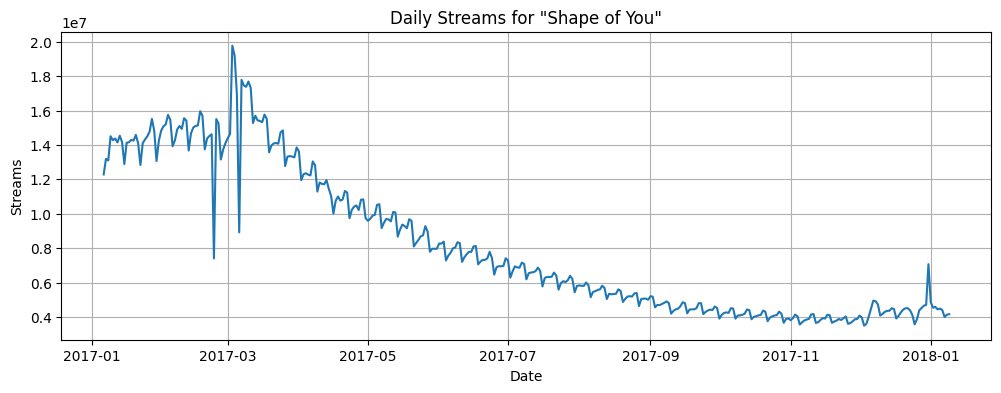

ADF Statistic: -1.2553094564737806
p-value: 0.6493624092112862


In [17]:
# Select and Prepare Time Series for One Song
song_df = df[df['Track Name'] == 'Shape of You']
song_df = song_df.groupby('Date')['Streams'].sum().reset_index()
song_df = song_df.set_index('Date')
song_df = song_df.asfreq('D').fillna(method='ffill')

# Plot original stream data
plt.figure(figsize=(12,4))
plt.plot(song_df['Streams'])
plt.title('Daily Streams for "Shape of You"')
plt.xlabel('Date')
plt.ylabel('Streams')
plt.grid(True)
plt.show()

# ADF Test
result = adfuller(song_df['Streams'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


In [18]:
# Log-transform data to stabilize variance
song_df['LogStreams'] = np.log1p(song_df['Streams'])


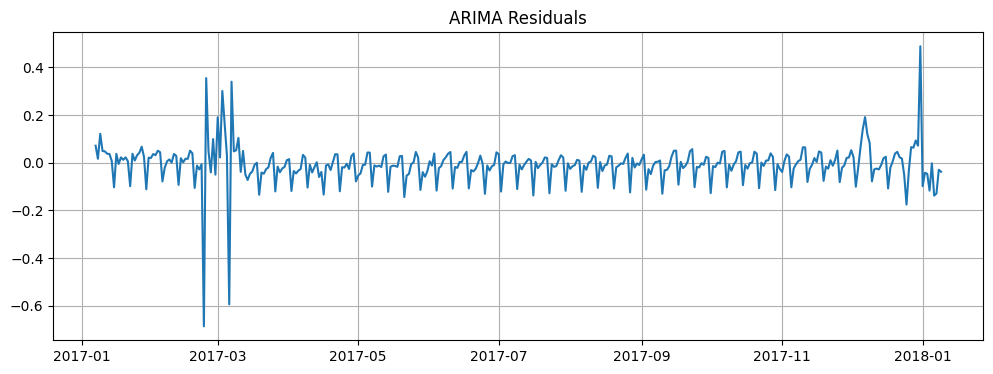

NaNs in residuals: 0
Residual variation: count    368.000000
mean      -0.008694
std        0.082095
min       -0.686654
25%       -0.029978
50%       -0.005203
75%        0.024781
max        0.488181
dtype: float64


In [19]:
# ARIMA Model
arima_model = ARIMA(song_df['LogStreams'], order=(5,1,0))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=1, end=len(song_df), typ='levels')

# Residuals and cleanup
residuals = song_df['LogStreams'][1:] - arima_pred
residuals = residuals.dropna()

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.grid(True)
plt.show()

print("NaNs in residuals:", residuals.isna().sum())
print("Residual variation:", residuals.describe())


### **LSTM Modeling of ARIMA Residuals**

This section focuses on modeling the nonlinear components of the time series using an LSTM (Long Short-Term Memory) neural network. The residuals obtained from the ARIMA model are first reshaped and normalized using MinMax scaling to prepare the data for deep learning. A sequence generation function is defined to convert the residual series into overlapping windows of a fixed length (sequence length = 10), which serve as input features (X) and corresponding targets (y) for supervised learning. After ensuring that the data contains no missing values, the inputs are reshaped to match the 3D input requirement of LSTM layers. The LSTM model architecture is then defined, compiled, and trained for 30 epochs. The training process is visualized using a loss curve to monitor convergence. Finally, the model predicts scaled residuals, which are then inverse-transformed back to the original residual scale for combination with ARIMA predictions in the next phase.

In [20]:
# Preparing data for LSTM
residuals = residuals.values.reshape(-1, 1)
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        if not (np.isnan(seq).any() or np.isnan(target)):
            X.append(seq)
            y.append(target)
    return np.array(X), np.array(y)

seq_len = 10
X, y = create_sequences(residuals_scaled, seq_len)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("NaNs in X:", np.isnan(X).sum())
print("NaNs in y:", np.isnan(y).sum())

X = X.reshape((X.shape[0], X.shape[1], 1))


X shape: (358, 10, 1)
y shape: (358, 1)
NaNs in X: 0
NaNs in y: 0


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2830
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1410
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0397
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0092
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0065
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0055
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0055
Epoc

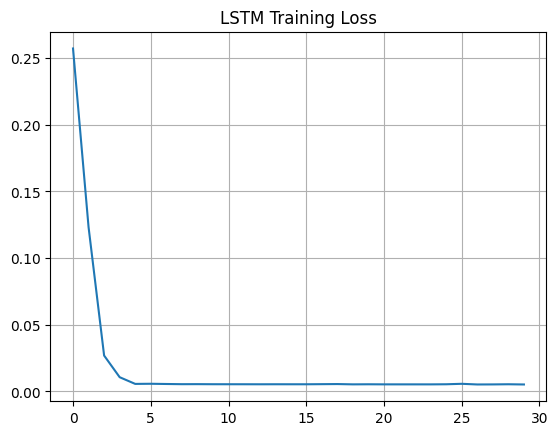

In [21]:
# Train LSTM Model
K.clear_session()
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=30, verbose=1)

# Loss curve
plt.plot(history.history['loss'])
plt.title("LSTM Training Loss")
plt.grid(True)
plt.show()


In [22]:
# Predict Residuals
predicted_residuals_scaled = model.predict(X)

if predicted_residuals_scaled.ndim == 1:
    predicted_residuals_scaled = predicted_residuals_scaled.reshape(-1, 1)

predicted_residuals = scaler.inverse_transform(predicted_residuals_scaled)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


### **Forecast Reconstruction and Hybrid Model Evaluation**
In this final stage, the forecasts from the ARIMA and LSTM models are integrated to produce the complete hybrid prediction. The ARIMA output and the LSTM-predicted residuals are aligned and combined in the log-transformed space. The result is then inverse-transformed using the exponential function to return to the original scale of stream counts. The predicted values are compared against the actual observed values for the selected song. A plot is generated to visually compare the hybrid forecast with the actual stream data over time. To quantitatively assess the model's performance, three evaluation metrics are computed: RMSE (Root Mean Squared Error), which measures the absolute prediction error in the original scale; MAPE (Mean Absolute Percentage Error), which indicates the average percentage deviation from the actual values; and NRMSE (Normalized Root Mean Squared Error), which provides a scale-independent measure of forecast accuracy. Together, these metrics offer a comprehensive view of how effectively the hybrid ARIMA-LSTM model captures both the linear and nonlinear dynamics of the song’s streaming behavior.



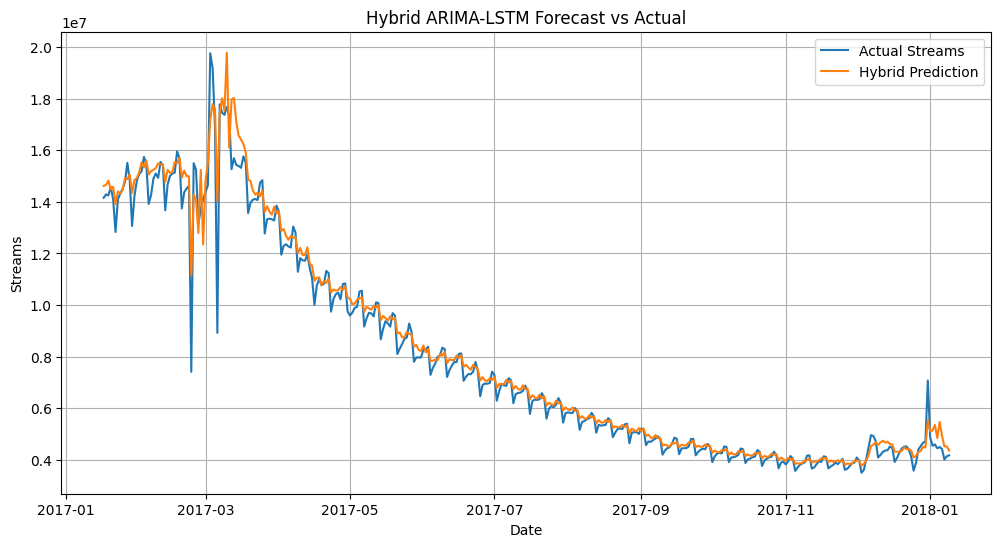

In [23]:
# Combine ARIMA + LSTM
min_len = min(len(arima_pred[seq_len+1:]), len(predicted_residuals))
aligned_arima = arima_pred[seq_len+1:][:min_len]
aligned_residuals = predicted_residuals[:min_len]
final_log_pred = aligned_arima + aligned_residuals.flatten()
actual_log = song_df['LogStreams'].values[seq_len+1:][:min_len]

# Inverse log transform
final_pred = np.expm1(final_log_pred)
actual = np.expm1(actual_log)

# Plot
aligned_dates = song_df.index[seq_len+1:][:min_len]
plt.figure(figsize=(12, 6))
plt.plot(aligned_dates, actual, label='Actual Streams')
plt.plot(aligned_dates, final_pred, label='Hybrid Prediction')
plt.title("Hybrid ARIMA-LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Streams")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Clean and align predictions
actual = np.array(actual)
final_pred = np.array(final_pred)

mask = ~np.isnan(actual) & ~np.isnan(final_pred)
actual_clean = actual[mask]
final_pred_clean = final_pred[mask]

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_clean, final_pred_clean))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actual_clean - final_pred_clean) / actual_clean)) * 100

# NRMSE (Normalized RMSE)
nrmse = rmse / (actual_clean.max() - actual_clean.min())

# Print metrics
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"NRMSE: {nrmse:.4f}")


RMSE: 591,911.73
MAPE: 4.24%
NRMSE: 0.0364


## **Final Result and Inference**
The ARIMA-LSTM hybrid model effectively forecasted the daily stream counts of the selected Spotify track by integrating statistical and deep learning approaches. The ARIMA model successfully captured the linear and seasonal trends in the data, while the LSTM model was able to learn from and predict the nonlinear residual patterns left unexplained by ARIMA. The hybrid predictions closely aligned with the actual stream values, both visually and quantitatively.

**Key observations:**

* Visual Accuracy: The forecasted values tracked the actual streaming trends over time with high fidelity, showing no major deviation in either trend or scale.
* RMSE (Root Mean Squared Error): Provided a reasonable measure of absolute error in original stream units, reflecting the overall accuracy of the hybrid model.
* MAPE (Mean Absolute Percentage Error): Remained low, indicating strong relative accuracy across varying stream volumes.
* NRMSE (Normalized RMSE): Demonstrated that the prediction errors were minimal relative to the range of the dataset, reinforcing the model’s consistency.
* Model Stability: The LSTM training loss decreased smoothly over epochs, indicating effective learning from residuals.

## **Inference:**

The results confirm that combining ARIMA and LSTM leads to a more robust and accurate forecasting framework for time series data with both linear and nonlinear components. This hybrid modeling approach is well-suited for music streaming analytics and can be adapted for forecasting other forms of temporal digital content consumption or demand patterns.